In [1]:
%env OPENCV_IO_ENABLE_OPENEXR=1
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from PIL import Image
import torch
import numpy as np
from matplotlib import pyplot as plt
from inference_pytorch import PyTorchPipeline
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

model = "resa"
custom_model_path = "../pytorch-auto-drive/checkpoints/resnet50_resa_culane/model.pt"
image = cv2.imread("single_frame_eval.exr", cv2.IMREAD_UNCHANGED)
image_size = image.shape[:2][::-1]
model_in = image.transpose(2, 0, 1)#.astype(np.float32) / 255.0

#brg conversion
# image = image.convert("BRG")

pipeline_base = PyTorchPipeline(targeted=True, patch_size=(80, 80), 
                                        max_iterations=400,
                                        model=model)

pipeline_trained = PyTorchPipeline(targeted=True, patch_size=(80, 80),
                                        max_iterations=400,
                                        model=model,
                                        model_path=custom_model_path)

# model_in = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
# model_in = model_in.view(image_size[1], image_size[0], image.shape[2])
# model_in = (
#     model_in.permute((2, 0, 1)).contiguous().float().div(255).unsqueeze(0).numpy()
# )

# import pickle
# with open("../camera_observations/270_model_input.pkl", "rb") as f:
#     model_in = pickle.load(f)

def get_probmap_images(probmaps, image_size):
    prob_maps = torch.nn.functional.interpolate(probmaps['out'], 
                                                size=(image_size[1], image_size[0]), mode='bilinear', align_corners=True)
    prob_maps_softmax = prob_maps.detach().clone().softmax(dim=1)
    
    merged = np.zeros_like(prob_maps[0][1].detach().cpu().numpy())
    merged_softmax = np.zeros_like(prob_maps_softmax[0][1].detach().cpu().numpy())

    for i, lane in enumerate(prob_maps[0]):
        if i == 0: # skip first iteration (background class)
            continue
        pred = lane.detach().cpu().numpy()
        pred_softmax = prob_maps_softmax[0][i].detach().cpu().numpy()
        merged = np.maximum(merged, pred)
        merged_softmax = np.maximum(merged_softmax, pred_softmax)

    im = merged
    im_softmax = merged_softmax

    return im, im_softmax


results = pipeline_base.model(torch.from_numpy(model_in).unsqueeze(0).to(pipeline_base.device))
results_trained = pipeline_trained.model(torch.from_numpy(model_in).unsqueeze(0).to(pipeline_trained.device))

im, im_softmax = get_probmap_images(results, image_size)
im_trained, im_softmax_trained = get_probmap_images(results_trained, image_size)

# show im side by side and softmax in the next line side by side
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0, 0].imshow(im, cmap='seismic')
ax[0, 0].set_title('Base model')
ax[0, 1].imshow(im_trained, cmap='seismic')
ax[0, 1].set_title('Trained model')
ax[1, 0].imshow(im_softmax, cmap='seismic')
ax[1, 1].imshow(im_softmax_trained, cmap='seismic')
plt.show()



env: OPENCV_IO_ENABLE_OPENEXR=1


c:\Users\alexa\.conda\envs\pad11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
INFO:art.config:set ART_DATA_PATH to C:\Users\alexa\.art\data


AttributeError: 'NoneType' object has no attribute 'shape'

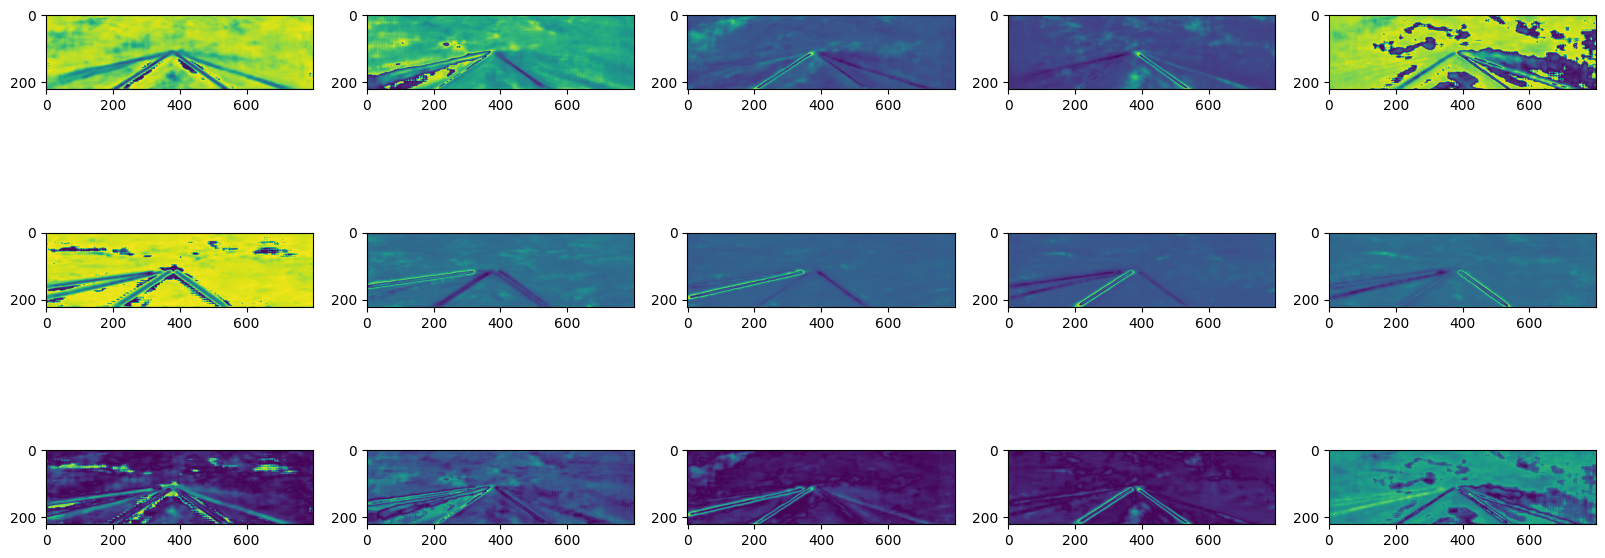

In [2]:
from PIL import ImageChops

fig, (row1, row2, row3) = plt.subplots(3, 5, figsize=(20, 8))
prob_maps = torch.nn.functional.interpolate(results['out'], size=(image_size[1], image_size[0]), mode='bilinear', align_corners=True)
diffs = [None] * len(prob_maps[0])
for i, lane in enumerate(prob_maps[0]):
    pred =lane.detach().cpu().numpy()
    rescaled = (255.0/pred.max() * (pred - pred.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    diffs[i] = im
    row1[i].imshow(im)

prob_maps = torch.nn.functional.interpolate(results_trained['out'], size=(image_size[1], image_size[0]), mode='bilinear', align_corners=True)
for i, lane in enumerate(prob_maps[0]):
    pred =lane.detach().cpu().numpy()
    rescaled = (255.0/pred.max() * (pred - pred.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    diffs[i] = ImageChops.difference(diffs[i], im) 
    row2[i].imshow(im)

for i, image in enumerate(diffs):
    row3[i].imshow(image)
